In [101]:
#tutorial: https://towardsdatascience.com/sentiment-analysis-of-stocks-from-financial-news-using-python-82ebdcefb638
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import urllib
import urllib.request
import requests
import nltk
import seaborn as sns
from bs4 import BeautifulSoup
import os
from flask import request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textwrap
pd.set_option('display.max_colwidth', -1)


C:\Users\PRM\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


# Parsing Stock Info

In [61]:
finwiz_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}

tickers = ['CVX','XOM','HFC']

for ticker in tickers:
    url = finwiz_url + ticker
    req = urllib.request.Request(url=url,headers={'user-agent': 'my-app/0.0.1'})
    response = urllib.request.urlopen(req)
    html = BeautifulSoup(response)
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [62]:
vr = news_tables['CVX']

# Top 10 Recent Articles

In [63]:
vr_tr = vr.findAll('tr')

for i, table_row in enumerate(vr_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 5:
        break

Chevron (CVX) Gains As Market Dips: What You Should Know
Mar-11-22 05:45PM  
Bidenomics: Is the Putin price hike real?
04:00PM  
10 Dividend Stocks Warren Buffett is Backing in 2022
01:01PM  
Recession: Here's what some top minds are saying
12:34PM  
High gas prices a consideration for workers returning to offices: YF Poll
12:19PM  
Here's Why SM Energy (SM) is an Attractive Investment Bet
12:02PM  


# Pulling Latest Articles for Ticker Symbol

In [64]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
pd.DataFrame(parsed_news,columns=('ticker','date','time','article')).head(15)

,ticker,date,time,article
0,CVX,Mar-11-22,05:45PM,Chevron (CVX) Gains As Market Dips: What You Should Know
1,CVX,Mar-11-22,04:00PM,Bidenomics: Is the Putin price hike real?
2,CVX,Mar-11-22,01:01PM,10 Dividend Stocks Warren Buffett is Backing in 2022
3,CVX,Mar-11-22,12:34PM,Recession: Here's what some top minds are saying
4,CVX,Mar-11-22,12:19PM,High gas prices a consideration for workers returning to offices: YF Poll
5,CVX,Mar-11-22,12:02PM,Here's Why SM Energy (SM) is an Attractive Investment Bet
6,CVX,Mar-11-22,11:59AM,4 Energy Stocks From the Promising Integrated Oil Industry
7,CVX,Mar-11-22,11:10AM,Gas prices rise around the world
8,CVX,Mar-11-22,10:52AM,Equinor (EQNR) Stops Russia Crude Trading Amid Ukraine Conflict
9,CVX,Mar-11-22,10:00AM,10 Value Stocks in Warren Buffetts Latest Portfolio


In [65]:
pd.DataFrame(parsed_news,columns=('ticker','date','time','article')).shape

(300, 4)

# Sentimental Analysis

In [66]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PRM\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [113]:
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news['date'])

parsed_and_scored_news['sentiment'] = np.where(parsed_and_scored_news['compound'] >= .05, 'positive',np.where((parsed_and_scored_news['compound'] >= -.05) & (parsed_and_scored_news['compound'] <= .05), 'neutral','negative'))

parsed_and_scored_news.head()


#compound - sentiment score - the higher the more positive (-1,1)
#

,ticker,date,time,headline,neg,neu,pos,compound,sentiment
0,CVX,2022-03-11,05:45PM,Chevron (CVX) Gains As Market Dips: What You Should Know,0.000,0.789,0.211,0.3400,positive
1,CVX,2022-03-11,04:00PM,Bidenomics: Is the Putin price hike real?,0.000,1.000,0.000,0.0000,neutral
2,CVX,2022-03-11,01:01PM,10 Dividend Stocks Warren Buffett is Backing in 2022,0.000,0.879,0.121,0.0258,neutral
3,CVX,2022-03-11,12:34PM,Recession: Here's what some top minds are saying,0.264,0.566,0.170,-0.2500,negative
4,CVX,2022-03-11,12:19PM,High gas prices a consideration for workers returning to offices: YF Poll,0.000,1.000,0.000,0.0000,neutral


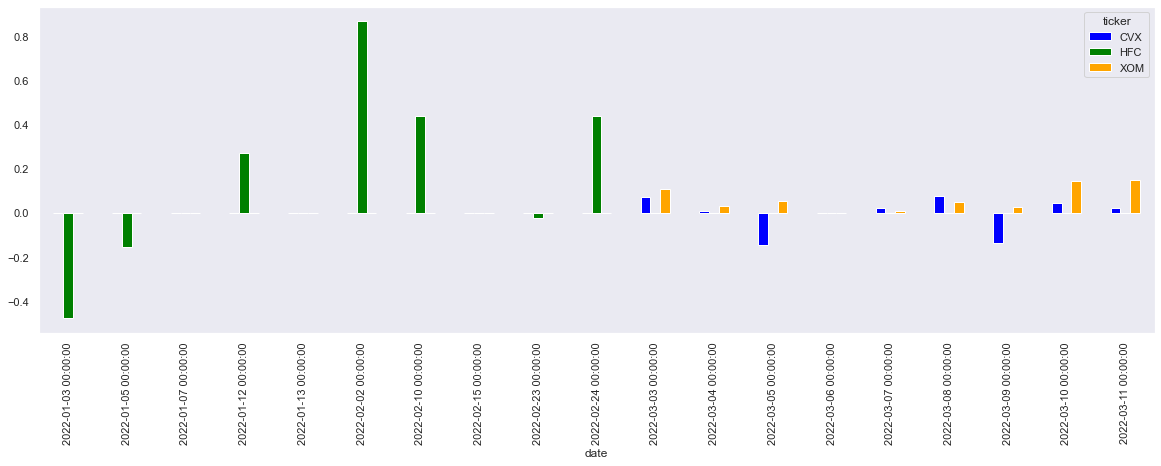

In [114]:
plt.rcParams['figure.figsize'] = [20, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.loc['2022-01-01':].plot(kind = 'bar',color= ['blue','green','orange', 'red','purple'])

plt.grid()

In [115]:
cols = ['Very Long Column Title ' + str(i) for i in range(2)]

# Split wide columns, you can then join these with any delimiter you'd like
cols = [textwrap.wrap(x, width=20) for x in cols]

# print(cols)
# [['Very Long Column', 'Title 0'], ['Very Long Column', 'Title 1']]


In [116]:
t = parsed_and_scored_news[parsed_and_scored_news['ticker']=='CVX']
t.head(15)

,ticker,date,time,headline,neg,neu,pos,compound,sentiment
0,CVX,2022-03-11,05:45PM,Chevron (CVX) Gains As Market Dips: What You Should Know,0.000,0.789,0.211,0.3400,positive
1,CVX,2022-03-11,04:00PM,Bidenomics: Is the Putin price hike real?,0.000,1.000,0.000,0.0000,neutral
2,CVX,2022-03-11,01:01PM,10 Dividend Stocks Warren Buffett is Backing in 2022,0.000,0.879,0.121,0.0258,neutral
3,CVX,2022-03-11,12:34PM,Recession: Here's what some top minds are saying,0.264,0.566,0.170,-0.2500,negative
4,CVX,2022-03-11,12:19PM,High gas prices a consideration for workers returning to offices: YF Poll,0.000,1.000,0.000,0.0000,neutral
5,CVX,2022-03-11,12:02PM,Here's Why SM Energy (SM) is an Attractive Investment Bet,0.000,0.615,0.385,0.6124,positive
6,CVX,2022-03-11,11:59AM,4 Energy Stocks From the Promising Integrated Oil Industry,0.000,0.556,0.444,0.5859,positive
7,CVX,2022-03-11,11:10AM,Gas prices rise around the world,0.000,1.000,0.000,0.0000,neutral
8,CVX,2022-03-11,10:52AM,Equinor (EQNR) Stops Russia Crude Trading Amid Ukraine Conflict,0.559,0.441,0.000,-0.7650,negative
9,CVX,2022-03-11,10:00AM,10 Value Stocks in Warren Buffetts Latest Portfolio,0.000,0.745,0.255,0.3400,positive


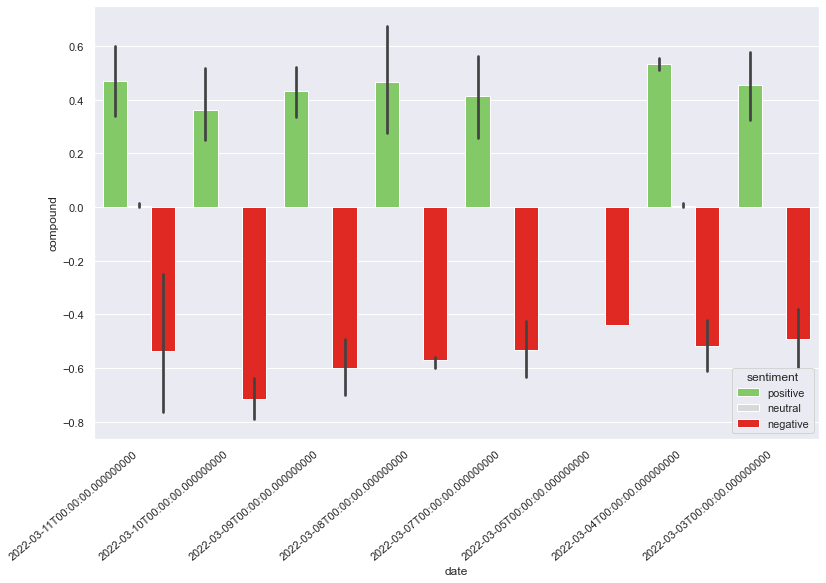

In [130]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

#7ed957 green
#FF0B04 red
#d9d9d9 neutral

colors = ["#7ed957",'#d9d9d9',"#FF0B04"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

#plt.rcParams['figure.figsize'] = [40, 6]
ax = sns.barplot(x='date', y='compound',hue ='sentiment', data=t)






ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()